In [ ]:
# default_exp audio.core

# Audio Core
> Basic audio opening, processing, and displaying functionality

In [ ]:
#export
# Contains code from github.com/fastaudio/fastaudio

# MIT License

# Original FastAudio implementation, Copyright (c) 2020 scart97

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

In [ ]:
#export
from __future__ import annotations

import torchaudio
import inspect

from IPython.display import Audio, display
from librosa.display import waveshow, specshow
from librosa import amplitude_to_db

from fastcore.dispatch import typedispatch

from fastai.imports import Path, mimetypes, plt
from fastai.torch_core import TensorBase, TensorImageBase
from fastai.vision.data import get_grid

from fastxtend.imports import *

In [ ]:
#hide
from fastxtend.test_utils import *
from nbdev.showdoc import *

In [ ]:
#export
audio_extensions = tuple(
    str.lower(k) for k, v in mimetypes.types_map.items() if v.startswith("audio/")
)

## TensorAudio -

In [ ]:
#export
def show_audio_signal(at, ctx, ax=None, title="", sep=0.03, **kwargs):
    ax = ifnone(ax, ctx)
    if ax is None:
        _, ax = plt.subplots()
    ax.axis(False)
    step = 0
    if at.channels==1: sep=0
    for i, channel in enumerate(at):
        step += 1 / (at.channels)
        top = sep if i==0 else 0
        ia = ax.inset_axes((0, 1-(step-top), 1, (1 / at.channels)-sep))
        waveshow(channel.cpu().numpy(), sr=at.sr, ax=ia, x_axis='time' if i==at.channels-1 else 'none', **kwargs)
    ax.set_title(title)

    return ax

In [ ]:
#export
class TensorAudio(TensorBase):
    "Semantic torch tensor that represents an audio. Can be created from files and has extra properties. Also knows how to show itself."

    @classmethod
    @delegates(torchaudio.load, keep=True)
    def create(cls, fn, **kwargs):
        "Creates audio tensor from file"
        sig, sr = torchaudio.load(fn, **kwargs)
        return cls(sig, sr=sr)

    def __new__(cls, x, sr=None, **kwargs):
        return super().__new__(cls, x, sr=sr, **kwargs)

    @property
    def samples(self):
        return self.shape[-1]

    @property
    def channels(self):
        return self.shape[-2]

    @property
    def duration(self):
        return self.samples / float(self.sr)

    def hear(self):
        "Listen to audio clip. Creates a html player."
        display(Audio(self.cpu(), rate=self.sr))

    @delegates(show_audio_signal)
    def show(self, ctx=None, hear=True, **kwargs):
        "Show audio clip using librosa. Pass `hear=True` to also display a html player to listen."
        if hear: self.hear()
        return show_audio_signal(self, ctx=ctx, **kwargs)

    def save(self, fn: Path, overwrite=True):
        "Save the audio into the specfied path"
        fn = Path.expanduser(fn)
        if not overwrite and Path.exists(fn):
            raise Exception("File already exists")
        torchaudio.save(fn, self.data, self.sr)

In [ ]:
#hide
a, sr = torchaudio.load(TEST_AUDIO)
ta = TensorAudio.create(TEST_AUDIO)

test_eq(a, ta)
test_eq(sr, ta.sr)
test_eq(ta.samples, ta.shape[-1])
test_eq(ta.channels, ta.shape[-2])
test_eq(ta.duration, ta.shape[-1]/sr)

<AxesSubplot:>

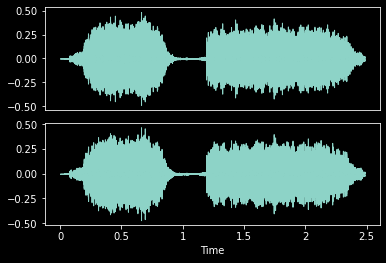

In [ ]:
#hide
ta.show(hear=False)

## TensorSpec -

In [ ]:
#export
def show_spectrogram(aspec, title="", ax=None, ctx=None, sep=0.025, to_db=False, **kwargs):
    ax = ifnone(ax, ctx)
    if ax is None:
        _, ax = plt.subplots()
    ax.axis(False)
    step = 0
    if aspec.channels==1: sep=0
    for i, channel in enumerate(aspec):
        step += 1 / (aspec.channels)
        top = sep if i==0 else 0
        ia = ax.inset_axes((0, 1-(step-top), 1, (1 / aspec.channels)-sep))
        if to_db: channel = amplitude_to_db(channel.cpu().numpy())
        else:     channel = channel.cpu().numpy()
        z = specshow(channel, ax=ia, **aspec._all_show_args(), x_axis='time' if i==aspec.channels-1 else None, **kwargs)
        if i == 0:  # Only colorbar the first one
            plt.colorbar(z, format=aspec._colorbar_fmt, ax=ax)
    ax.set_title(title)

    return ax

In [ ]:
#exporti
def get_usable_kwargs(func, kwargs, exclude=None):
    exclude = ifnone(exclude, [])
    defaults = {
        k: v.default
        for k, v in inspect.signature(func).parameters.items()
        if k not in exclude
    }
    usable = {k: v for k, v in kwargs.items() if k in defaults}
    return {**defaults, **usable}

In [ ]:
#export
class TensorSpec(TensorImageBase):
    """
    Semantic torch tensor that represents an Audio Spectrogram.
    Contains all of the functionality of a normal tensor,
    but has extra properties and knows how to show itself.
    """
    @classmethod
    def create(cls, 
        ta:Tensor, 
        settings:dict|None=None
    ):
        """Create an TensorSpec from a torch tensor"""
        spec = cls(ta)
        spec._settings = settings
        return spec

    @property
    def duration(self):
        # spectrograms round up length to fill incomplete columns, so subtract 0.5 to compensate
        return (self.hop_length * (self.shape[-1] - 0.5)) / self.sr

    @property
    def width(self):
        return self.shape[-1]

    @property
    def height(self):
        return self.shape[-2]

    @property
    def channels(self):
        return self.shape[-3]

    def _all_show_args(self):
        proper_kwargs = get_usable_kwargs(specshow, self._settings, 
                                          exclude=["ax", "kwargs", "x_axis", "data"])
        proper_kwargs.update({"y_axis": "log"})
        proper_kwargs.update(self._show_args)
        return proper_kwargs

    @property
    def _colorbar_fmt(self):
        return "%+2.0f dB" if "to_db" in self._settings and self.to_db else "%+2.0f"

    def __getattr__(self, name):
        if name == "settings":
            return self._settings
        if not name.startswith("_"):
            return self._settings[name]
        raise AttributeError(
            f"{self.__class__.__name__} object has no attribute {name}"
        )

    @delegates(show_spectrogram)
    def show(self, ctx=None, ax=None, title="", **kwargs):
        "Show spectrogram using librosa"
        return show_spectrogram(self, ctx=ctx, ax=ax, title=title, **kwargs)

In [ ]:
#hide
import inspect
def grab_settings(method, **kwargs):
    args = {k:v.default for k,v in inspect.signature(method).parameters.items() if v.default != inspect.Parameter.empty}
    return {k: kwargs[k] if k in kwargs.keys() else args[k] for k in args.keys()}

0.525
0.0


<AxesSubplot:>

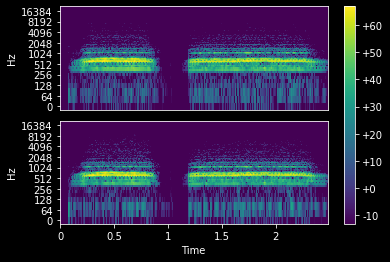

In [ ]:
#hide
from torchaudio.transforms import MelSpectrogram, Spectrogram
spec = TensorSpec.create(Spectrogram(hop_length=400, n_fft=1024)(ta), settings={**{'sr':ta.sr},**grab_settings(Spectrogram, hop_length=400, n_fft=1024)})
spec.show(to_db=True)

0.525
0.0


<AxesSubplot:>

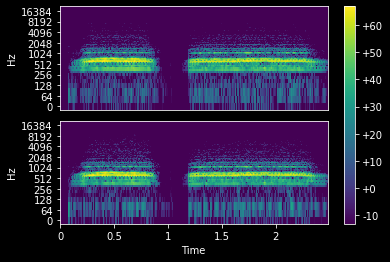

In [ ]:
#hide
from torchaudio.transforms import MelSpectrogram, Spectrogram
spec = TensorSpec.create(Spectrogram(hop_length=400, n_fft=1024)(ta), settings={**{'sr':ta.sr},**grab_settings(Spectrogram, hop_length=400, n_fft=1024)})
spec.show(to_db=True)

## TensorMelSpec -

In [ ]:
#export
class TensorMelSpec(TensorSpec):

    @classmethod
    def create(cls, 
        ta:Tensor, 
        settings:dict|None=None
    ):
        """Create an TensorMelSpec from a torch tensor"""
        mel = cls(ta)
        mel._settings = settings
        return mel

    def _all_show_args(self):
        proper_kwargs = get_usable_kwargs(specshow, self._settings, 
                                          exclude=["ax", "kwargs", "x_axis", "data"])
        proper_kwargs.update({"y_axis": "mel"})
        proper_kwargs.update(self._show_args)
        return proper_kwargs

    @property
    def duration(self):
        # spectrograms round up length to fill incomplete columns, so subtract 0.5 to compensate
        return (self.hop_length * (self.shape[-1] - 0.5)) / self.sr

    @property
    def width(self):
        return self.shape[-1]

    @property
    def height(self):
        return self.shape[-2]

    @property
    def channels(self):
        return self.shape[-3]

<AxesSubplot:>

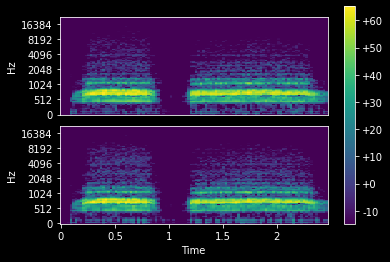

In [ ]:
#hide
mel = TensorMelSpec.create(MelSpectrogram(ta.sr, n_fft=1024, hop_length=1024, n_mels=112)(ta), settings={**{'sr':ta.sr},**grab_settings(MelSpectrogram, sample_rate=ta.sr, n_fft=1024, hop_length=1024, n_mels=112)})
mel.show(to_db=True)

In [ ]:
mel.shape

torch.Size([2, 128, 107])

In [ ]:
mel.channels

2